In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wconfig as wc
import re
wc.dispy()

ofts_file = 'D:/python_work/tianchi_o2o/data/ccf_offline_stage1_train1000.xlsx'

oft_path = 'D:/python_work/tianchi_o2o/data/backup/ccf_offline_stage1_train.csv'
ont_path = 'D:/python_work/tianchi_o2o/data/backup/ccf_online_stage1_train.csv'
testt_path = 'D:/python_work/tianchi_o2o/data/backup/ccf_offline_stage1_test_revised.csv'

In [1]:
oft = pd.read_csv(oft_path,keep_default_na=False)
#按数据初始格式读入。出现'null'的地方，实际是字符串
#keep_default_na参数，这个参数的作用是决定要不要保留默认应该转换的缺失值列表，
#将这个参数设为False之后同时不定义na_values参数，就可以在读取文件时不将任何值转换为缺失值NaN。
#否则read_csv读入数据之后，会将含缺失值的int类型数据转化为float类型。

In [4]:
抽样数据并保存
#ofts = oft.sample(n=10000) #随机抽样1000个样本

#ofts.to_excel(ofts_file, index=False)

In [2]:
ofts2 = pd.read_excel(ofts_file, index_col=None, keep_default_na=False)

In [ ]:
字段说明：
1. Date字段表示的是用户的消费日期，有可能使用了优惠券（Coupon_id不为空），也有可能没有使用（Coupon_id为空）。
2. User_id (用户编号)、 Merchant_id (商户编号) ，这两个字段都没有缺失值。
3. Coupon_id (消费时使用的优惠券编号)，null表示无优惠券消费。
4. Discount_rate (折扣率)
5. Distance (离店距离)，为空表示无此信息，0表示小于500米，10表示大于5公里。
6. Date_received (领取优惠券日期)

In [3]:
# 备份 ofts
ofts = ofts2.copy()
ofts.head(30)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,4572702,450,1532,30:5,0,20160530,null
1,3084043,3532,6521,50:5,1,20160114,null
2,1315547,3381,9776,10:5,1,20160129,20160228
3,3129642,450,3732,30:5,0,20160428,null
4,7218531,2099,12034,100:10,0,20160204,20160219
5,244970,7717,13423,20:1,0,20160523,20160602
6,5226466,8422,null,null,0,null,20160315
7,5677720,1644,9600,20:5,0,20160324,null
8,6067200,1433,8735,30:5,5,20160213,null
9,5489344,4434,null,null,0,null,20160506


In [103]:
# 处理各个特征字段

# Date字段转换为时间类型，并设置时间索引
# Date字段表示的是用户的消费日期，有可能使用了优惠券（Coupon_id不为空），也有可能没有使用（Coupon_id为空）。
ofts['Date']=ofts['Date'].apply(lambda x: pd.NaT if (x=='null') 
                                else pd.to_datetime(x, format='%Y%m%d'))



# User_id、 Merchant_id 字段转为 字符串类型。这两个字段都没有缺失值，可以直接转换。
ofts['User_id'] = ofts['User_id'].astype(str)
ofts['Merchant_id'] = ofts['Merchant_id'].astype(str)

# Coupon_id也转为 字符串类型。注意它里面有缺失值，要分情况转换。
ofts['Coupon_id']=ofts['Coupon_id'].apply(lambda x: None if (x=='null') else str(x))


# 处理 Discount_rate, 转换为数值型
def D_rate(x):
    if x=='null':
        y=np.NaN  # 先处理成缺失值，便于统计，等输入算法的时候再处理成1
    elif re.match(r'\d+:\d+', x):  #如果是满减形式
        y=(int(x.split(':')[0]) - int(x.split(':')[1])) / int(x.split(':')[0])
    else:
        y=float(x) #如果是0.95这样的折扣形式
    return y

ofts['Discount_rate'] = ofts['Discount_rate'].apply(D_rate)


# Date_received 字段转为日期格式
ofts['Date_received']=ofts['Date_received'].apply(lambda x: pd.NaT if (x=='null') 
                                                else pd.to_datetime(x,format='%Y%m%d'))
#ofts['Date_received'] = pd.to_datetime(ofts['Date_received'],format='%Y%m%d')

# 处理 Distance 离店距离
#缺失值先赋值为空，后面再根据均值或者中位数或者众数来确定
ofts['Distance'] = ofts['Distance'].apply(lambda x: np.NaN if x=='null' else np.int32(x))

In [27]:
#ofts["Date_used"] = ofts[ofts['Date'] - ofts['Date_received']]
ofts['Date'] - ofts['Date_received']

0          NaT
1          NaT
2      30 days
3          NaT
4      15 days
5      10 days
6          NaT
7          NaT
8          NaT
9          NaT
         ...  
9990       NaT
9991       NaT
9992       NaT
9993       NaT
9994       NaT
9995       NaT
9996       NaT
9997       NaT
9998       NaT
9999       NaT
Length: 10000, dtype: timedelta64[ns]

In [ ]:
#ofts[(ofts['Distance']!='null')&(ofts['Date_received'].notna())]  #有领取日期，但没有距离数据的数据共 106003 行
#ofts[(ofts['Distance']!='null')&(ofts['Date_received'].isna())]
#ofts[(ofts['Distance']=='null')&(ofts['Coupon_id'].isna())]
ofts[(ofts['Distance']=='null')&(ofts['Coupon_id'].notna())]
#ofts.groupby('User_id').apply(lambda x:x[(x['Distance']=='null')&(x['Distance']!='null')])
##执行不出来 oft.groupby('User_id').apply(lambda x:x[(x['Distance']=='null')&(x['Distance']!='null')])


In [ ]:
print(ofts.dtypes)
print(type(ofts))
ofts



In [104]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=["Total", "Percent" ])
    #ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation= 90 )
    fig=sns.barplot(ms.index, ms["Percent"],color="green",alpha=0.8)
    plt.xlabel("Features", fontsize=15)
    plt.ylabel("Percent of missing values", fontsize=15)
    plt.title("Percent missing data by feature", fontsize=15)
    return ms

,Total,Percent
Date,5632,56.320
Date_received,3933,39.330
Discount_rate,3933,39.330
Coupon_id,3933,39.330
Distance,645,6.450
Merchant_id,0,0.000
User_id,0,0.000


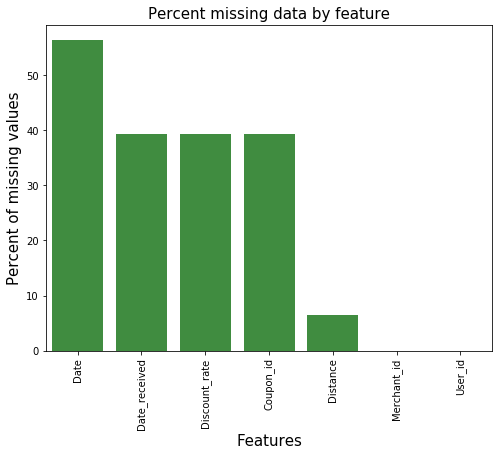

In [105]:
missingdata(ofts)

In [7]:
# 总体描述
ofts.describe(include='all')
#用户和商家ID无空值，总记录数是175万。他们代表的是线下消费者或者领取了优惠券的用户，
#从记录数量上也可以看到 Date_received 和 Date 的总和大约是 User_id的数量。
#优惠券ID表示领取的优惠券，他和 Date_received 的数据是一致的，共有 105万。
#Date 表示消费日期。如果用户领了优惠券，消费的时候默认是使用消费券的（消费日期和优惠券ID都存在）。
#只有消费日期，没有优惠券ID的，说明是没领优惠券就去店里消费的。
#没有消费日期，但却有优惠券ID的，是领了券，没去消费的人。
#既没领券，也没消费的用户是不存在于本数据集中的。
#Discount_rate是优惠率，只要领了优惠券，就有这个数据。
#以优惠券为例，来说明describe的输出结果含义
#count表示总记录数。unique表示去重之后的记录数。top是出现最多的记录，freq是出现次数。
#first是针对时间数据说的，表示最早的时间，last表示最晚的时间。

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
count,10000,10000,6067,6067.000,9355.000,6067,4368
unique,9733,1703,1228,nan,nan,166,182
top,3272334,3381,7610,nan,nan,2016-01-29 00:00:00,2016-05-22 00:00:00
freq,3,754,213,nan,nan,400,65
first,NaN,NaN,NaN,nan,nan,2016-01-01 00:00:00,2016-01-01 00:00:00
last,NaN,NaN,NaN,nan,nan,2016-06-15 00:00:00,2016-06-30 00:00:00
mean,NaN,NaN,NaN,0.843,2.336,NaN,NaN
std,NaN,NaN,NaN,0.091,3.475,NaN,NaN
min,NaN,NaN,NaN,0.500,0.000,NaN,NaN
25%,NaN,NaN,NaN,0.833,0.000,NaN,NaN


In [ ]:
#没有离店信息的记录，只有508个（1万中），占比较小，说明只是个别少数人。
ofts[ofts['Distance'].notna()] 
# #没有领取优惠券，但是有离店距离信息的有4002个（1万中）
#ofts[ofts['Coupon_id'].isna() & ofts['Distance'].notna()]  
# 领了优惠券但是没消费、并且有离店距离信息的，有4965个（1万中）
#ofts[ofts['Date'].isna() & ofts['Coupon_id'].notna() & ofts['Distance'].notna()] 
# 领了优惠券但是没消费、没有离店距离信息的，有579个（1万中）
ofts[ofts['Date'].isna() & ofts['Coupon_id'].notna() & ofts['Distance'].isna()] 
#yes_no = lambda x: 'yes' if x else 'no'

In [106]:
# 设置缺失值和非缺失值的标签，便于做交叉表统计
ofts['Coup'] = ofts['Coupon_id'].apply(lambda x: 'Coup_yes' if x else 'Coup_no')
ofts['DateL'] = ofts['Date'].apply(lambda x: 'DateL_yes' if pd.notna(x) else 'DateL_no')
ofts['Dist'] = ofts['Distance'].apply(lambda x: 'Dist_yes' if pd.notna(x) else 'Dist_no')
ofts['Disc'] = ofts['Discount_rate'].apply(lambda x: 'Disc_yes' if pd.notna(x) else 'Disc_no')
ofts['DateR'] = ofts['Date_received'].apply(lambda x: 'DateR_yes' if pd.notna(x) else 'DateR_no')

In [107]:
# 是否消费、是否领取了优惠券等几种情况下，各自是否有距离信息
pd.crosstab([ofts.DateL], ofts.DateR, margins=True)
# 从交叉表结果可看出，领取优惠券但是没有去消费的记录有5527个，其中有5019个记录了离店信息；
# 无优惠券的普通消费有4043个，全部有离店信息；
# 使用优惠券消费的记录有430个。其中37条记录没有离店信息，另外393个有离店信息。

DateR,DateR_no,DateR_yes,All
DateL,,,
DateL_no,0,5632,5632
DateL_yes,3933,435,4368
All,3933,6067,10000


In [10]:
# 计算优惠券领取到消费日的间隔。
# 领取但没有消费、以及无优惠券的普通消费，这个计算结果都为 NaN.
ofts["Date_used"] = ofts['Date'] - ofts['Date_received']


In [ ]:
# 对优惠券消费间隔的分析

#消费时使用了优惠券
ofts['Date_received'] & ofts['Date']
ofts['Date'] - ofts['Date_received']  # 用券间隔，有可能大于

#没有领取优惠券，普通消费
ofts['Date_received'].isna() & ofts['Date']
# 结果为缺失值, 因为没有领取优惠券，不清楚消费的起始日期。如果能构建一个起始日期的话，也可以代替领取日期来做运算。
#比如该用户的消费频率、该商户的消费频率、该用户在该商户的消费频率、该用户领券后的消费频率、该商户的用券消费频率、
#该用户在该商户的用券消费频率
比如该用户在A商户消费的时间间隔是17天，但在商户B用券消费的时间间隔是12天，那会不会在领取A商户的优惠券后，再次消费的
时间间隔缩短到15以内？
比如该用户在A商户消费的时间间隔是17天，但商户A的用户，不用券的消费间隔是20天，发券后的消费间隔变成了16天，那该用户
领券后消费隔间会不会缩短到15天以内？
ofts['Date'] - ofts['Date_received']  

# 领取了优惠券，但是没有消费
ofts['Date_received'] & ofts['Date'].isna()
ofts['Date'] - ofts['Date_received']  # 结果为缺失值，表示领券后，超过15日仍未消费

In [ ]:
# 用户消费间隔 user_trans_days
#接下来解决这个代码运行时间过长的问题！！！！

oftsnotna = ofts[ofts['Date'].notna()]
date_group = oftsnotna['Date'].groupby(oftsnotna['User_id'])
avgdate = date_group.apply(lambda x:(x.max()-x.min())/x.count()).reset_index().drop_duplicates()
#ofts.merge(avgdate, how='left', left_on='User_id', right_on='User_id')
ofts['user_trans_days'] = ofts['User_id'].apply(lambda x: avgdate.Date if x==avgdate.index else np.NaN)
#type(avgdate)

In [131]:
#ofts['user_trans_days'][ofts['user_trans_days'].notna()]
ofts['user_trans_days'].sort_values(ascending=False)
#avgdate[avgdate > 0]
    
    

0      nan
1      nan
2      nan
3      nan
4      nan
5      nan
6      nan
7      nan
8      nan
9      nan
        ..
9990   nan
9991   nan
9992   nan
9993   nan
9994   nan
9995   nan
9996   nan
9997   nan
9998   nan
9999   nan
Name: user_trans_days, Length: 10000, dtype: float64

In [137]:
tmp = date_group.apply(lambda x: 'yes' if x.max()!=x.min() else 'no')
tmp[tmp=='yes']
oftsnotna['Date'] 

User_id
1036051    yes
1086995    yes
1103054    yes
114875     yes
1242210    yes
1332819    yes
1431321    yes
1437132    yes
1450795    yes
1531298    yes
          ... 
6929894    yes
7159213    yes
7160236    yes
7195726    yes
7269661    yes
7286817    yes
7320038    yes
7338284    yes
858704     yes
9045       yes
Name: Date, Length: 135, dtype: object

In [117]:
avgdate.index

Index(['1000890', '1005774', '1006180', '1006321', '1006705', '1007582',
       '1009872', '1013767', '1016772', '1016869',
       ...
       '987517', '988259', '988959', '989283', '990840', '995779', '997459',
       '997833', '997874', '998867'],
      dtype='object', name='User_id', length=4225)

In [99]:
ofts[ofts.duplicated('User_id')].sort_values('User_id')

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Coup,DateL,Dist,Disc,DateR,Date_used,user_trans_days,user_merch_trans_days,merch_trans_days
9526,1036051,6485,None,nan,0.000,NaT,2016-04-10,Coup_no,DateL_yes,Dist_yes,Disc_no,DateR_no,NaT,9 days 12:00:00,9 days 12:00:00,0 days 23:51:49.090909
9468,1046239,5341,None,nan,0.000,NaT,2016-04-27,Coup_no,DateL_yes,Dist_yes,Disc_no,DateR_no,NaT,0 days 00:00:00,0 days 00:00:00,0 days 10:37:15.696821
3175,1074261,2762,13144,0.833,3.000,2016-04-27,NaT,Coup_yes,DateL_no,Dist_yes,Disc_yes,DateR_yes,NaT,0 days 00:00:00,NaT,0 days 00:00:00
2368,1086099,1810,None,nan,0.000,NaT,2016-02-22,Coup_no,DateL_yes,Dist_yes,Disc_no,DateR_no,NaT,0 days 00:00:00,0 days 00:00:00,24 days 16:00:00
7718,1086995,5070,14018,0.833,0.000,2016-05-22,2016-05-23,Coup_yes,DateL_yes,Dist_yes,Disc_yes,DateR_yes,1 days,10 days 12:00:00,0 days 00:00:00,0 days 00:00:00
9040,1097609,3381,9776,0.500,4.000,2016-01-29,NaT,Coup_yes,DateL_no,Dist_yes,Disc_yes,DateR_yes,NaT,NaT,NaT,0 days 05:34:39.681274
1269,1103054,5341,None,nan,0.000,NaT,2016-04-24,Coup_no,DateL_yes,Dist_yes,Disc_no,DateR_no,NaT,26 days 00:00:00,26 days 00:00:00,0 days 10:37:15.696821
8436,1107862,7974,9274,0.900,0.000,2016-01-27,NaT,Coup_yes,DateL_no,Dist_yes,Disc_yes,DateR_yes,NaT,NaT,NaT,2 days 09:44:20.869565
9715,114875,3621,None,nan,0.000,NaT,2016-04-17,Coup_no,DateL_yes,Dist_yes,Disc_no,DateR_no,NaT,21 days 12:00:00,21 days 12:00:00,1 days 01:16:48
9833,1242210,2934,None,nan,1.000,NaT,2016-04-10,Coup_no,DateL_yes,Dist_yes,Disc_no,DateR_no,NaT,33 days 00:00:00,33 days 00:00:00,0 days 17:46:40


In [91]:
ofts.drop_duplicates().User_id.groupby('User_id').count().sort_values(ascending=False)

KeyError: 'User_id'

In [63]:
# 每用户、每商户的消费间隔 user_merch_trans_days
def dayfunc2(x):
    tmp = ofts[(ofts['Merchant_id']==x['Merchant_id']) & (ofts['User_id']==x['User_id'])].drop_duplicates()
    return (tmp['Date'].max()-tmp['Date'].min())/tmp['Merchant_id'].count()
ofts['user_merch_trans_days']=ofts.apply(dayfunc2, axis=1)

# 商户消费间隔 merch_trans_days
def dayfunc3(x):
    tmp = ofts[(ofts['Merchant_id']==x['Merchant_id'])].drop_duplicates()
    return (tmp['Date'].max()-tmp['Date'].min())/tmp['Merchant_id'].count()
ofts['merch_trans_days']=ofts.apply(dayfunc3, axis=1)

In [66]:
ofts[ofts['user_trans_days'] > pd.Timedelta(' 0 days 0 hours 0 minutes 1 seconds')]

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Coup,DateL,Dist,Disc,DateR,Date_used,user_trans_days,user_merch_trans_days,merch_trans_days
289,4067504,5039,None,nan,0.000,NaT,2016-01-23,Coup_no,DateL_yes,Dist_yes,Disc_no,DateR_no,NaT,33 days 00:00:00,33 days 00:00:00,28 days 14:24:00
309,489724,5341,None,nan,0.000,NaT,2016-04-01,Coup_no,DateL_yes,Dist_yes,Disc_no,DateR_no,NaT,1 days 12:00:00,1 days 12:00:00,0 days 10:37:15.696821
320,2203296,5717,None,nan,0.000,NaT,2016-01-22,Coup_no,DateL_yes,Dist_yes,Disc_no,DateR_no,NaT,11 days 00:00:00,11 days 00:00:00,1 days 19:05:48.387096
338,3047688,4453,None,nan,1.000,NaT,2016-01-08,Coup_no,DateL_yes,Dist_yes,Disc_no,DateR_no,NaT,60 days 12:00:00,60 days 12:00:00,30 days 06:00:00
344,4628859,3710,None,nan,0.000,NaT,2016-05-02,Coup_no,DateL_yes,Dist_yes,Disc_no,DateR_no,NaT,3 days 12:00:00,3 days 12:00:00,2 days 18:24:00
365,858704,2592,None,nan,0.000,NaT,2016-04-15,Coup_no,DateL_yes,Dist_yes,Disc_no,DateR_no,NaT,3 days 12:00:00,3 days 12:00:00,6 days 16:00:00
376,439201,1080,None,nan,1.000,NaT,2016-05-27,Coup_no,DateL_yes,Dist_yes,Disc_no,DateR_no,NaT,12 days 00:00:00,12 days 00:00:00,1 days 23:43:38.181818
385,489724,5341,None,nan,0.000,NaT,2016-03-29,Coup_no,DateL_yes,Dist_yes,Disc_no,DateR_no,NaT,1 days 12:00:00,1 days 12:00:00,0 days 10:37:15.696821
417,3826326,1945,None,nan,0.000,NaT,2016-05-25,Coup_no,DateL_yes,Dist_yes,Disc_no,DateR_no,NaT,60 days 12:00:00,0 days 00:00:00,4 days 00:35:07.317073
457,4824993,3241,None,nan,0.000,NaT,2016-02-15,Coup_no,DateL_yes,Dist_yes,Disc_no,DateR_no,NaT,64 days 00:00:00,0 days 00:00:00,0 days 00:00:00


In [54]:
df = pd.DataFrame([[4, 9],[4, 16], [9, 27]], columns=['A', 'B'])
df

,A,B
0,4,9
1,4,16
2,9,27


In [32]:
df.count()

A    3
B    3
dtype: int64

In [55]:
def func(x):
    tmp=df[df['A']==x['A'].max()]
    return tmp['A'].count()
df['C']=df.apply(func, axis=1)

In [56]:
df

,A,B,C
0,4,9,2
1,4,16,2
2,9,27,1


In [73]:

import pandas as pd
import numpy as np
 
#字符串类型的，使用None赋值为空值
#数值类型的，使用numpy.NaN赋值为空值
#时间类型的，使用pandas.NaT赋值为空值
testframe = pd.DataFrame({'c1':['w', 'b', 'c'],
            'c2':[1, np.NaN, 3],
            'c3':[pd.Timestamp('2018-10-11'), pd.Timestamp('2018-09-23'), pd.NaT],
            'c4':[pd.NaT,pd.NaT,pd.NaT]})
testframe 


,c1,c2,c3,c4
0,w,1.000,2018-10-11,NaT
1,b,nan,2018-09-23,NaT
2,c,3.000,NaT,NaT


In [76]:
testframe = pd.DataFrame(columns=['c1','c2','c3','c4'])

In [78]:
testframe['c4'].max()-testframe['c4'].min()
#(ofts['Date'].max()-ofts['Date'].min())/3
#testframe['c4'].count()

nan

In [30]:
# 用户的用券消费间隔
user_Ctrans_day
#商户的每用户平均用券消费间隔
user_Ctrans_days_of_merch
# 每用户、每商户的用券消费间隔
user_merch_Ctrans_days
# 用户的每商户平均用券消费间隔
merch_Ctrans_days_of_user

nan

In [245]:
# 用透视表（还没完全掌握）
ofts.pivot_table(values=["Coupon_id"], index=['DateL','C'],  columns=['Dist'],aggfunc='count', margins=True)
#https://blog.csdn.net/hustqb/article/details/78086394

Coupon_id                  
Dist             no      yes      All
DateL C                              
no    yes   508.000 5019.000 5527.000
yes   no        nan    0.000      nan
      yes    37.000  393.000  430.000
All         545.000 5412.000 5957.000

In [223]:
ofts[ofts['Distance'].isna()].shape #4023

(545, 11)

In [68]:
# 找到使用最多的优惠券，以及了解这些优惠券都是相同的商家吗？
oft['Coupon_id'].value_counts()  #使用最多的优惠券ID是 7610, 被使用了4.6万多次。
# 看看这个优惠券是哪些商家的
#oft['Merchant_id'][oft['Coupon_id']=='7610'].drop_duplicates()  #发现是属于同一家商户的。并且一张也没有被消费，Date全都为空。

null     701602
7610      46729
2418      29284
11951     26035
8555      26009
1480      24815
1807      24500
111       21760
2840      21693
5054      21402
          ...  
11145         1
2434          1
5739          1
10207         1
10149         1
5232          1
12866         1
12476         1
12957         1
364           1
Name: Coupon_id, Length: 9739, dtype: int64

In [ ]:
# 再次确认同一个优惠券属于不同商家的情况存在？
# 这个问题可以转化为：对优惠券ID和商家ID求分组，计算每个分组里的非重复条目是否大于1
oftg = oft.groupby(['Merchant_id','Coupon_id']).count()
oftg[oftg['User_id'] > 1]  #发现有不少结果

In [55]:
#看看其中一个商家和优惠券都重复的是什么情况：原来是有不同的客户领取了不同的优惠券。
oft[(oft['Merchant_id']==2) & (oft['Coupon_id']=='7354')]

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
Date,,,,,,,
NaT,1579490,2,7354,100:20,5.000,2016-05-20,NaT
NaT,1091900,2,7354,100:20,10.000,2016-05-19,NaT
NaT,952912,2,7354,100:20,10.000,2016-05-15,NaT
NaT,3789187,2,7354,100:20,10.000,2016-05-16,NaT
NaT,2121631,2,7354,100:20,10.000,2016-05-20,NaT
NaT,1657650,2,7354,100:20,10.000,2016-05-18,NaT
NaT,6621282,2,7354,100:20,2.000,2016-05-17,NaT


In [37]:
#oftg = oft.groupby(['Merchant_id','Coupon_id']).count()
#oftg[oftg['User_id'] > 1]  #发现有不少结果
ofts[(ofts['Coupon_id']=='null') & (ofts['Merchant_id']==76)]

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
Date,,,,,,,
2016-03-12,6200339,76,null,null,0.000,NaT,2016-03-12


In [64]:

oft['2016-02-06':'2016-02-06']['Distance'] #时间切片，只可用年、年月、年月日格式，用其他格式比如月日、月、日，这三种都不是唯一子集，运行会出错或运行不出结果。
#而且用年月日的格时，必须用 '2016-02-06':'2016-02-06'这样的形式。
#print(type(oft['2016-02']))
oft.to_period('M')  #只显示月份
py = oft.to_period('Q')  #只显示年份
#oft.to_period('Q')  #只显示季度
py.index.asfreq('Q')
ofts.resample('w').sum()

,User_id,Merchant_id
DateF,,
2016-01-03,29811773,27105
2016-01-10,62305014,53909
2016-01-17,52914477,39323
2016-01-24,53167059,63378
2016-01-31,62170187,53803
2016-02-07,37131314,56983
2016-02-14,23289683,17225
2016-02-21,50595487,46555
2016-02-28,47408464,38011


In [2]:

print(oft.dtypes)


User_id           int64
Merchant_id       int64
Coupon_id        object
Discount_rate    object
Distance         object
Date_received    object
Date             object
dtype: object


In [142]:
ofts[ofts['Coupon_id'].isna() & ofts['Date_received'].notna()]

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
Date,,,,,,,


In [54]:
#被领取，并且被使用的优惠券有 6865种。
#优惠券最多被领取并消费使用了的次数是 3106 次。
cc = oft['Coupon_id'][(oft['Coupon_id']!='null') & (oft['Date']!='null')].value_counts()
print(cc)
print( cc.mean())  #平均每个优惠券被领取并消费了10次。

11539    3106
10323    2397
111      1800
12034    1705
5686     1611
2418     1473
4773     1305
9776      969
6103      779
7751      747
         ... 
11247       1
5264        1
13470       1
3791        1
1012        1
1599        1
3048        1
11435       1
13323       1
10296       1
Name: Coupon_id, Length: 6865, dtype: int64
10.980626365622724


In [55]:
#被领取但没消费的优惠券有 701602张。
#优惠券最多被领取并消费使用了的次数是 3106 次。
cc = oft['Coupon_id'][(oft['Coupon_id']=='null') & (oft['Date']!='null')].value_counts()
print(cc)
print( cc.mean())  #平均每个优惠券被领取并消费了10次。

null    701602
Name: Coupon_id, dtype: int64
701602.0


In [ ]:
values = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
df.fillna(value=values)
    A   B   C   D
0   0.0 2.0 2.0 0
1   3.0 4.0 2.0 1
2   0.0 1.0 2.0 5
3   0.0 3.0 2.0 4

In [ ]:
基于pandas的数据分析之数据类型转化踩坑总结
https://blog.csdn.net/yhyr_ycy/article/details/80383060
pandas 缺失值与空值处理
https://blog.csdn.net/lwgkzl/article/details/80948548
缺而不失——pandas中常见缺失值处理方法    
https://www.jianshu.com/p/8231ac523a13
Pandas日期数据处理：如何按日期筛选、显示及统计数据    
https://www.jianshu.com/p/b91e3ae940ec

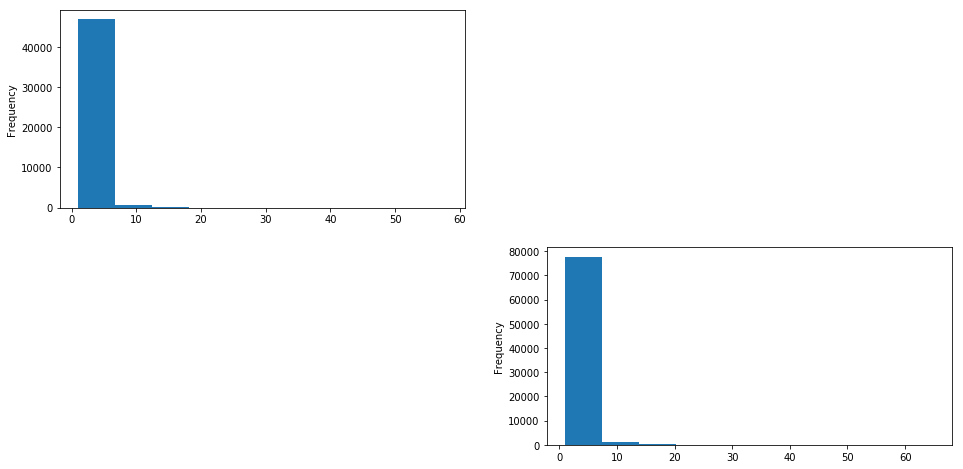

In [54]:
#oft这张表记录的是

#print("describe:\n", oft.describe())
# 哪些用户使用了优惠券，以及领取次数
# 可看到总共有54万用户，其中 5054119 这个用户领取了 264次优惠券，8196 这个用户只领取了1次。
uc1 = oft['2016-02'].User_id.value_counts().sort_values(ascending=False).reset_index()
uc2 = oft['2016-03'].User_id.value_counts().sort_values(ascending=False).reset_index()
uc1.index
plt.figure(figsize=(16,8))
plt.subplot(221)
uc1['User_id'].plot( kind='hist', bins=10)
plt.subplot(224)
uc2['User_id'].plot( kind='hist', bins=10)

In [30]:
print(type(uc))
print("User_id unique list:\n", uc)
#plt.figure(figsize=(11,6))
#uc.plot(kind='line', label='Distance')
#plt.legend(loc='best')

<class 'pandas.core.frame.DataFrame'>
User_id unique list:
           index  User_id
0       5054119      264
1       2751537      155
2       2949273      137
3       6655171      136
4       4840568      134
5       6641735      132
6       3977895      127
7       5219700      126
8       5409340      121
9       2952204      119
...         ...      ...
539428  6819836        1
539429   530431        1
539430  3637262        1
539431  4502572        1
539432  1519640        1
539433  1509407        1
539434  3571758        1
539435  3559476        1
539436  5611594        1
539437     8196        1

[539438 rows x 2 columns]


<class 'pandas.core.series.Series'>
User_id unique list:
 6820630    2
5237025    2
6157126    2
1565373    1
5057524    1
7164624    1
6814413    1
131788     1
475851     1
240330     1
          ..
2215283    1
5314939    1
124273     1
5778799    1
6217067    1
3054953    1
3506645    1
3450215    1
580966     1
3983071    1
Name: User_id, Length: 997, dtype: int64
每个商户发放的优惠券数量:
 3381    142190
450      73866
5341     66747
760      60280
2934     40645
2709     37085
7555     36916
1569     34518
3532     31578
6485     31218
         ...  
1961         1
8816         1
6373         1
631          1
633          1
1657         1
8832         1
5342         1
644          1
8582         1
Name: Merchant_id, Length: 8415, dtype: int64
每商户发放优惠券均数为： 208.54236482471777
每张优惠券被领取的次数:
 null     701602
7610      46729
2418      29284
11951     26035
8555      26009
1480      24815
1807      24500
111       21760
2840      21693
5054      21402
          ...  
10779         1
277           

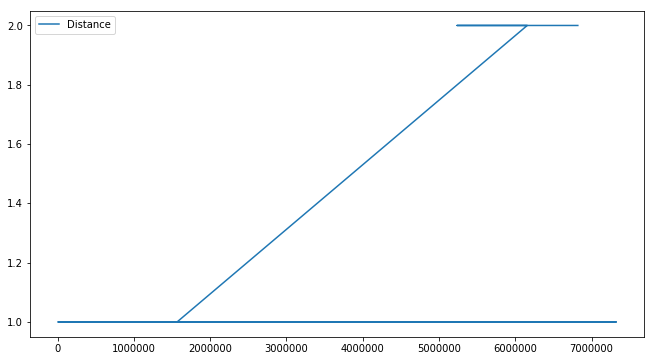

In [13]:
# 哪些商户发放了优惠券，以及领取次数
# 总商户达到了8415家，3381这个商户发放了14万张优惠券，平均发放优惠券208张。
print("每个商户发放的优惠券数量:\n", oft['Merchant_id'].value_counts())
print('每商户发放优惠券均数为：', oft['Merchant_id'].value_counts().mean())

# 都有哪些优惠券，以及领取次数
print("每张优惠券被领取的次数:\n", oft['Coupon_id'].value_counts())  #共有9739张优惠券被领取？消费？
print('优惠券领取均数为：', oft['Coupon_id'].value_counts().mean())

In [2]:
# 都有哪些优惠券折扣率，以及领取次数

print("Discount_rate unique list:\n", oft['Discount_rate'].value_counts())


Discount_rate unique list:
 null       701602
30:5       270712
100:10     182554
200:20     111046
20:5        91013
20:1        51705
50:5        47379
100:30      38196
200:30      29327
300:30      28979
            ...  
0.2           110
0.6            58
200:5          57
300:20         56
0.7            54
30:20          24
300:10         23
200:100        12
50:30           9
150:5           7
Name: Discount_rate, Length: 46, dtype: int64


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,DateF
DateF,,,,,,,,
2016-02-17,1439408,2632,null,null,0,null,20160217,2016-02-17
2016-02-21,114747,5341,111,30:5,0,20160127,20160221,2016-02-21
2016-02-18,114747,5341,111,30:5,0,20160207,20160218,2016-02-18
2016-02-21,114747,3381,9776,10:5,0,20160129,20160221,2016-02-21
2016-02-06,205174,1169,null,null,0,null,20160206,2016-02-06
2016-02-14,205174,1169,4627,50:20,0,20160206,20160214,2016-02-14
2016-02-05,1380272,2099,12034,100:10,1,20160201,20160205,2016-02-05
2016-02-06,1380272,5341,7751,50:10,0,20160201,20160206,2016-02-06
2016-02-05,1380272,5341,111,30:5,0,20160201,20160205,2016-02-05


In [43]:
#读取测试文件
testt = pd.read_csv(testt_path)
#找出线下文件中，与测试数据中Coupon_id相同的行数
#行数用哪个方法计算？value_counts计算出的不重复的值是1118，但这个不是行数
cs_testt = len(oft[oft.Coupon_id.isin(testt.Coupon_id)].Coupon_id)
print('counts of testt Coupon_id is \n', cs_testt)
#线下文件中，所有的Coupon_id数
coup_not_null = oft[pd.isna(oft['Coupon_id'])]
print("All Coupon_id counts is :\n", len(coup_not_null['Coupon_id']))



'''
cs_testt = oft[oft.Coupon_id.isin(testt.Coupon_id)].Coupon_id.unique().value_counts()
print('counts of testt Coupon_id is \n', cs_testt)
#线下文件中，所有的Coupon_id数
print("All Coupon_id counts is :\n", oft['Coupon_id'].value_counts())
'''

'''
pandas判断是否为空值
pandas 空值定义为numpy.nan
对整体的series或Dataframe判断是否未空，用isnull() 
eg: 
pd.isnull(df1) #df1是dataframe变量
对单独的某个值判断，可以用 np.isnan() 
eg: np.isnan(df1.ix[0,3]) #对df1的第0行第3列判断
'''

counts of testt Coupon_id is 
 93565
All Coupon_id counts is :
 701602


'\ncs_testt = oft[oft.Coupon_id.isin(testt.Coupon_id)].Coupon_id.unique().value_counts()\nprint(\'counts of testt Coupon_id is \n\', cs_testt)\n#线下文件中，所有的Coupon_id数\nprint("All Coupon_id counts is :\n", oft[\'Coupon_id\'].value_counts())\n'

In [18]:
print("Merchant_id unique:\n", oft['Merchant_id'].unique(), oft['Merchant_id'].value_counts())
print("Distance unique:\n", oft['Distance'].unique(),oft['Distance'].value_counts())
print("Coupon_id unique:\n", oft['Coupon_id'].unique(), oft['Coupon_id'].value_counts())

Merchant_id unique:
 [2632 4663 3381 ... 7235 3699 1405] 3381    142190
450      73866
5341     66747
760      60280
2934     40645
2709     37085
7555     36916
1569     34518
3532     31578
6485     31218
1433     28786
1469     27432
6901     25673
3621     25601
4660     25005
2099     24357
6454     24265
2436     18914
6434     17922
4663     16549
5717     16509
7019     14867
7717     14188
4860     14102
1080     13799
4142     13203
7974     13018
1041     11838
2146     11691
8181     11180
         ...  
1222         1
5319         1
5811         1
7863         1
2694         1
7385         1
7814         1
5171         1
8790         1
1622         1
7419         1
244          1
7408         1
6064         1
1263         1
1067         1
4016         1
7787         1
3688         1
8104         1
1961         1
8816         1
6373         1
631          1
633          1
1657         1
8832         1
5342         1
644          1
8582         1
Name: Merchant_id, Length: 8